In [24]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Name: Marjan Sadeghi
# Name: Ruiqi Hu

# Business Understanding and Overall Conclusion

The Breast Cancer Dataset from Kaggle ([https://www.kaggle.com/datasets/reihanenamdari/breast-cancer](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer)) contains demographic, pathological, and receptor-related information for 4,024 patients diagnosed with breast cancer. The predictors include age, race, marital status, tumor size, lymph node involvement, stage classifications (T Stage, N Stage, 6th Stage, and A Stage), tumor grade, differentiation, and hormone receptor status. Together, these variables provide a detailed clinical and demographic profile of each patient. The target variable, survival status (Alive or Dead), captures the long-term outcome of interest and allows us to model the factors associated with breast cancer mortality.

The primary goal of this project was to build and analyze neural network architectures capable of predicting survival outcomes using the wide-and-deep learning framework. This architecture integrates a wide component, which captures memorized interactions among categorical features, with a deep component that models higher-order nonlinear relationships across both categorical and numerical variables. Because breast cancer outcomes depend on combinations of staging information, receptor expression, and tumor aggressiveness, the hybrid structure of wide-and-deep learning is well suited for this type of tabular clinical dataset.

From a business and healthcare analytics perspective, survival modeling plays an important role in risk stratification, treatment prioritization, and clinical decision support. Identifying patients at higher risk of poor outcomes allows healthcare providers to allocate resources more effectively and tailor interventions based on clinical severity. Unlike simple linear models that may miss complex interactions, wide-and-deep networks can capture both interpretable cross-feature relationships and deeper nonlinear trends, reflecting the multifactorial nature of cancer progression.

In this project, we trained multiple wide-and-deep models with increasing deep-branch complexity and evaluated them using stratified 5-fold cross-validation. Because the dataset contains an imbalanced target distribution (approximately 85 percent Alive and 15 percent Dead), we used ROC AUC, PR AUC, and F1 score to capture both ranking performance and minority-class sensitivity. Across all architectures, the models achieved consistent results, with ROC AUC values around 0.86–0.87, PR AUC near 0.96–0.97, and F1 scores around 0.94. Increasing the depth of the deep branch produced only small numerical improvements, and paired t-tests showed no statistically significant differences between architectures. An additional stratified 80/20 train–test split confirmed that the best-performing model did not overfit, with stable performance across both training and unseen data.

We also compared the best wide-and-deep model to a deep-only multilayer perceptron. Both cross-validation metrics and McNemar’s test on paired predictions showed no significant difference in performance. This suggests that, for a moderately sized dataset with informative and well-encoded features, the deep component alone is sufficient to capture most clinically relevant interactions, while the wide component does not add measurable predictive value.

Finally, we examined the latent representations learned by the network. PCA applied to the final hidden-layer embeddings revealed a meaningful structure in the learned feature space: patients with similar survival outcomes clustered gradually rather than discretely, and cancer stages aligned with a clear progression across the embedding space. This reflects the network’s ability to internalize clinically coherent relationships between disease severity, receptor status, and survival patterns.

Overall, the project demonstrates that wide-and-deep learning provides a robust and interpretable framework for modeling structured medical data. The models generalized well across cross-validation folds, maintained stability on held-out data, and produced latent representations consistent with known clinical patterns. While the wide branch did not yield measurable improvements over the deep-only architecture in this dataset, the hybrid approach remains a flexible method for integrating categorical interactions and nonlinear effects. The findings highlight how moderately complex neural architectures can uncover meaningful relationships in clinical datasets and support data-driven approaches to understanding breast cancer survival.


# Preparation

In [26]:
# ============================================================
# 1.1 Define and prepare your class variables.
# ============================================================
df = pd.read_csv("/Users/ruiqihu/Desktop/CS 7324/Lab 5/Breast_Cancer.csv")

print("Raw shape:", df.shape)

if "T Stage " in df.columns:
    df = df.rename(columns={"T Stage ": "T_Stage"})

df["Status_bin"] = df["Status"].map({"Alive": 1, "Dead": 0})

# we don’t need the original text label anymore for modeling
df = df.drop(columns=["Status"])

categorical_cols = [
    "Race",
    "Marital Status",
    "T_Stage",
    "N Stage",
    "6th Stage",
    "differentiate",
    "Grade",
    "A Stage",
    "Estrogen Status",
    "Progesterone Status",
]

numeric_cols = [
    "Age",
    "Tumor Size",
    "Regional Node Examined",
    "Reginol Node Positive",
    "Survival Months",
]

# numeric → fill with median
for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# categorical → fill with mode
for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

X = df[categorical_cols + numeric_cols]
y = df["Status_bin"]

print("Final X shape (before encoding):", X.shape)
print("Target distribution:\n", y.value_counts())


categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols),
    ]
)

Raw shape: (4024, 16)
Final X shape (before encoding): (4024, 15)
Target distribution:
 Status_bin
1    3408
0     616
Name: count, dtype: int64


We intentionally did not apply PCA or any other dimensionality reduction to the raw features before training, because wide-and-deep networks are designed to learn task-specific embeddings directly from the full feature set.

In [27]:
# ============================================================
# 1.2 Identify groups of features to cross 
# ============================================================

# create cross-product categorical features
df["T_by_N"] = df["T_Stage"].astype(str) + "_" + df["N Stage"].astype(str)
df["Grade_by_Stage"] = df["Grade"].astype(str) + "_" + df["6th Stage"].astype(str)
df["ER_PR"] = df["Estrogen Status"].astype(str) + "_" + df["Progesterone Status"].astype(str)

# add them to categorical columns for one-hot encoding
categorical_cols_extended = categorical_cols + ["T_by_N", "Grade_by_Stage", "ER_PR"]


## 1.2 Analysis
In this dataset, each categorical feature represents a clinically meaningful aspect of breast cancer diagnosis or patient characteristics. When deciding which features to cross, the main goal is to capture interactions that have a logical and medical basis, rather than to arbitrarily increase dimensionality. Cross-product features are most valuable when the joint effect of two variables has predictive power that cannot be explained by their individual effects. For this dataset, variables related to tumor staging and hormone receptor status are the most suitable candidates for crossing because their combinations are known to influence survival outcomes.
One important cross is between T_Stage and N Stage. The T_Stage describes the size and extent of the primary tumor, while the N Stage indicates the degree of lymph node involvement. In clinical oncology, these two factors are not interpreted independently; they are combined to define the TN staging system, which forms the foundation of the cancer classification used by oncologists worldwide. For instance, a patient with T1N1 and a patient with T3N1 may both have positive lymph nodes, but the prognosis differs substantially because tumor size also matters. Crossing these two features allows the model to recognize these nuanced patterns that represent actual clinical staging relationships.

Another useful interaction is between Grade and 6th Stage. Grade measures how abnormal the cancer cells appear under a microscope, often reflecting the biological aggressiveness of the tumor, while the 6th Stage represents the pathological stage of the disease based on tumor size, node involvement, and metastasis. Patients with the same 6th Stage but different tumor grades often experience different survival outcomes. By combining these variables, the model can capture differences such as the fact that a Stage II cancer with Grade 3 cells might have a worse prognosis than a Stage II cancer with Grade 1 cells. This cross therefore helps incorporate how aggressiveness interacts with the overall disease stage.

A third medically justified cross is between Estrogen Status and Progesterone Status. These two variables measure whether the tumor expresses specific hormone receptors. They are almost always interpreted together in clinical practice, as tumors that are positive for both receptors respond better to hormonal therapy and generally have a better prognosis. A model that only considers them separately would miss the clinically meaningful joint categories such as double-positive (ER+/PR+), single-positive (ER+/PR− or ER−/PR+), and double-negative (ER−/PR−), each of which has distinct treatment responses and outcomes.

We chose only clinically meaningful crosses (T×N, Grade×Stage, ER×PR) because these combinations are known to drive prognosis and treatment decisions. We deliberately did not cross demographic variables (such as race or marital status) with staging variables, because this would explode dimensionality without a strong medical mechanism.

Other potential crosses, such as combining demographic variables like Race or Marital Status with staging features, were not included. These combinations may introduce spurious relationships or confounding effects unrelated to biological mechanisms. Similarly, crossing A Stage with T_Stage or N Stage would add redundancy because A Stage already summarizes tumor extent and lymph node involvement. Numerical features such as Tumor Size, Regional Node Examined, or Age are continuous and can be captured effectively by model nonlinearities or standardization, so explicit cross-products are unnecessary.

In summary, the chosen cross-product features T_Stage × N Stage, Grade × 6th Stage, and Estrogen Status × Progesterone Status reflect interactions that are both clinically interpretable and statistically useful. These pairs jointly describe how the physical extent of the tumor, its biological aggressiveness, and its hormonal characteristics interact to determine prognosis. Including them provides the model with richer structural information about cancer progression without introducing irrelevant or redundant dimensions.

In [28]:
# ============================================================
# 1.3 Choose and explain metrics
# ============================================================

# split data (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# build model pipeline with preprocessing
final_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=500))
    ]
)

# fit model
final_model.fit(X_train, y_train)

# predictions
y_proba = final_model.predict_proba(X_test)[:, 1]   # predicted probability of Alive=1
y_pred = final_model.predict(X_test)

# evaluation metrics
roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print("ROC AUC:", round(roc, 3))
print("Average Precision (PR AUC):", round(ap, 3))
print("F1:", round(f1, 3))


ROC AUC: 0.864
Average Precision (PR AUC): 0.967
F1: 0.937


## 1.3 Analysis
The model predicts Status_bin, where 1 represents a patient who was alive and 0 represents a patient who was dead. We know that the classes are imbalanced (3408 alive vs 616 dead), so accuracy is not an appropriate evaluation metric. A model that always predicts “alive” would already achieve about 85% accuracy but would fail to identify patients who actually died, which is the more critical outcome. Because the clinically meaningful result is the minority class (death), we selected metrics that evaluate how well the model separates the two classes and how effectively it identifies the rare outcome. For this reason, we used three evaluation metrics: ROC AUC, Average Precision (PR AUC), and F1 score.

The ROC AUC of 0.864 shows that our model has good discriminative ability overall. ROC AUC measures the model’s ranking quality across all possible thresholds, meaning it evaluates how well the model distinguishes between alive and dead patients regardless of the cutoff point. In practical terms, it answers the question: if we take one alive and one dead patient at random, how often does the model assign a higher predicted survival probability to the alive patient? This metric is appropriate because, in real-world applications, different stakeholders might choose different thresholds depending on available resources or the acceptable level of sensitivity.

However, ROC AUC can appear high even when the dataset is imbalanced, since it gives weight to performance on both the majority and minority classes. Therefore, we also calculated the Average Precision (PR AUC), which was 0.967. PR AUC focuses directly on the precision–recall relationship and emphasizes performance on the minority class. In this medical context, a high PR AUC means that when the model predicts a patient as high-risk (dead), it is usually correct, and it also captures most of the actual death cases. This metric aligns well with the practical objective of minimizing false negatives, since failing to detect at-risk patients could have serious consequences, whereas issuing extra warnings is relatively less costly.

Finally, we included the F1 score, which was 0.937. The F1 score is the harmonic mean of precision and recall and provides a balanced single-number summary when a specific decision threshold is used. If the model were deployed to trigger alerts or follow-up screenings, the F1 score would indicate how well it balances identifying true deaths while avoiding unnecessary false alarms.

In summary, we chose ROC AUC to measure overall discrimination ability, Average Precision to handle class imbalance and reflect the importance of correctly identifying high-risk patients, and F1 to summarize performance at a chosen threshold. Together, these metrics are far more informative and meaningful than accuracy for this dataset because they better represent the clinical and practical goals of correctly identifying patients at risk of death while maintaining robust overall performance.


In [29]:
# ============================================================
# 1.4 Compare Stratified 5-Fold vs Stratified 10-Fold
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

def run_cv(n_folds):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    roc_scores, ap_scores, f1_scores = [], [], []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("model", LogisticRegression(max_iter=500))
            ]
        )
        model.fit(X_tr, y_tr)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)

        roc_scores.append(roc_auc_score(y_val, y_val_proba))
        ap_scores.append(average_precision_score(y_val, y_val_proba))
        f1_scores.append(f1_score(y_val, y_val_pred))

    return (
        np.mean(roc_scores),
        np.mean(ap_scores),
        np.mean(f1_scores)
    )

# run 5-fold
mean_roc_5, mean_ap_5, mean_f1_5 = run_cv(5)
print("5-fold CV -> ROC AUC:", round(mean_roc_5, 3),
      "PR AUC:", round(mean_ap_5, 3),
      "F1:", round(mean_f1_5, 3))

# run 10-fold
mean_roc_10, mean_ap_10, mean_f1_10 = run_cv(10)
print("10-fold CV -> ROC AUC:", round(mean_roc_10, 3),
      "PR AUC:", round(mean_ap_10, 3),
      "F1:", round(mean_f1_10, 3))

# final model on full train, evaluate on held-out test
final_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=500))
    ]
)
final_model.fit(X_train, y_train)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = final_model.predict(X_test)

print("\nTest ROC AUC:", round(roc_auc_score(y_test, y_test_proba), 3))
print("Test PR AUC:", round(average_precision_score(y_test, y_test_proba), 3))
print("Test F1:", round(f1_score(y_test, y_test_pred), 3))


5-fold CV -> ROC AUC: 0.861 PR AUC: 0.964 F1: 0.94
10-fold CV -> ROC AUC: 0.861 PR AUC: 0.964 F1: 0.939

Test ROC AUC: 0.864
Test PR AUC: 0.967
Test F1: 0.937


## 1.4 Analysis

We compared Stratified 5-Fold and Stratified 10-Fold Cross-Validation to determine an appropriate validation strategy for this dataset. The dataset contains 4024 observations, with 3408 alive and 616 deceased patients, making it moderately sized and clearly imbalanced. Because of this imbalance, stratification was used in every splitting procedure to ensure that each fold preserved the original class proportions. This avoids situations where a validation fold may contain too few deceased cases, which would make metrics such as ROC AUC, PR AUC, or F1 unstable or biased toward the majority class.

The cross-validation results from our logistic regression baseline show that both splitting strategies yield nearly identical performance. Using 5-fold CV, we obtained ROC AUC = 0.861, PR AUC = 0.964, and F1 = 0.940. Using 10-fold CV produced ROC AUC = 0.861, PR AUC = 0.964, and F1 = 0.939. These values are virtually the same, which indicates that increasing the number of folds does not lead to more reliable estimates for this dataset. Since 10-fold CV requires roughly twice the computation time but does not improve stability, the 5-fold configuration is the more efficient and equally reliable choice.

It is also important to justify when an 80/20 hold-out split is appropriate. In class, the threshold for dataset size was described as follows: small datasets fall between 1000 and 3000 samples, and large datasets contain more than 30,000 samples. Our dataset of 4024 samples does not qualify as large by this definition and falls into the intermediate range between the two categories. This means that an 80/20 split cannot be used as the primary evaluation method, because the dataset is not large enough to rely on a one-time hold-out for robust model assessment. For this reason, we use stratified 5-fold cross-validation as the main validation approach.

The stratified 80/20 split in Section 1.3 serves a different purpose. It functions as an independent final test set, separate from cross-validation, to simulate how the model would perform on new real-world cases. On this hold-out test set, the logistic regression baseline achieved ROC AUC = 0.864, PR AUC = 0.967, and F1 = 0.937. These test metrics closely match the cross-validation averages, which indicates that the model generalizes well and does not exhibit performance degradation when applied to unseen data.

Using both stratified 5-fold cross-validation and a stratified 80/20 hold-out test set offers a balanced and realistic evaluation structure. Cross-validation provides repeated and stable estimates of generalization across multiple partitions, while the independent test set offers a final unbiased check of performance. This two-stage approach reflects how predictive models are typically tuned and validated in practice, especially in medical or business contexts where class imbalance and moderate dataset sizes are common.

In summary, we selected Stratified 5-Fold Cross-Validation as our primary validation method because it provides stable performance estimates while remaining computationally efficient, and we used an 80/20 stratified split only as a final evaluation step rather than a replacement for cross-validation. This approach matches the dataset size guidelines discussed in class, handles class imbalance appropriately, and provides a reliable assessment of model generalization.

# Modeling

Input dim: 74
Model 1 val acc: 0.8894410133361816
Model 2 val acc: 0.8919254541397095
Model 3 val acc: 0.8894410133361816


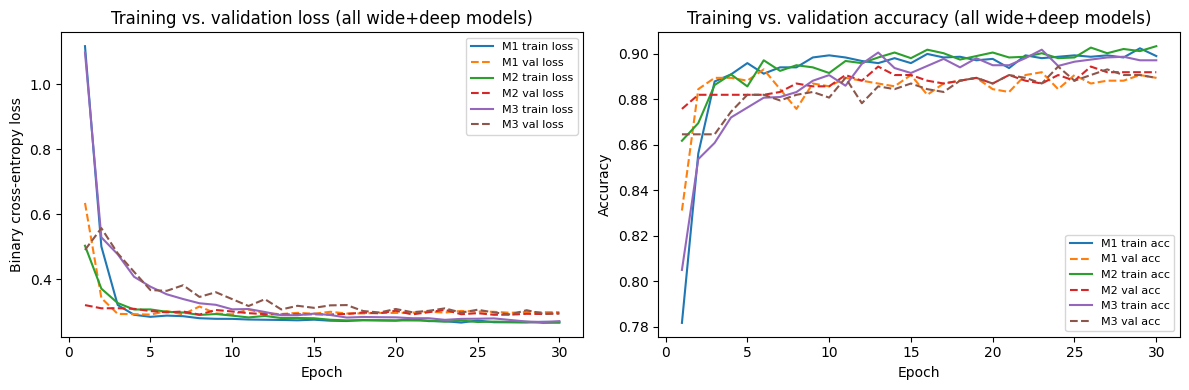

In [30]:
# ============================================================
# 2.1 Wide + Deep models (three variants) with Keras
# ============================================================

# 1) make sure df is present; we continue from earlier preprocessing
# we will create the three cross features we decided in 1.2
df["T_by_N"] = df["T_Stage"].astype(str) + "_" + df["N Stage"].astype(str)
df["Grade_by_Stage"] = df["Grade"].astype(str) + "_" + df["6th Stage"].astype(str)
df["ER_PR"] = df["Estrogen Status"].astype(str) + "_" + df["Progesterone Status"].astype(str)

categorical_cols = [
    "Race",
    "Marital Status",
    "T_Stage",
    "N Stage",
    "6th Stage",
    "differentiate",
    "Grade",
    "A Stage",
    "Estrogen Status",
    "Progesterone Status",
    "T_by_N",
    "Grade_by_Stage",
    "ER_PR",
]

numeric_cols = [
    "Age",
    "Tumor Size",
    "Regional Node Examined",
    "Reginol Node Positive",
    "Survival Months",
]

# 2) one-hot encode with pandas so Keras gets a pure numeric array
X = df[categorical_cols + numeric_cols]
y = df["Status_bin"].values.astype("float32")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)
X_array = X_encoded.values.astype("float32")

# 3) train/val split (same 80/20 logic)
X_train, X_val, y_train, y_val = train_test_split(
    X_array,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

input_dim = X_train.shape[1]
print("Input dim:", input_dim)

# ------------------------------------------------------------
# helper to build wide+deep
# wide branch = raw inputs
# deep branch = MLP
# ------------------------------------------------------------
def build_wide_deep(input_dim, deep_units, dropout_rate=0.0, name="wd"):
    inputs = keras.Input(shape=(input_dim,), name="inputs")
    wide_part = inputs
    x = inputs
    for u in deep_units:
        x = layers.Dense(u, activation="relu")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    concat = layers.concatenate([wide_part, x])
    outputs = layers.Dense(1, activation="sigmoid")(concat)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# 4) build 3 different models
model1 = build_wide_deep(input_dim, deep_units=[32], dropout_rate=0.0, name="wd_m1")
model2 = build_wide_deep(input_dim, deep_units=[64, 32], dropout_rate=0.1, name="wd_m2")
model3 = build_wide_deep(input_dim, deep_units=[128, 64, 32], dropout_rate=0.2, name="wd_m3")

# 5) train and collect histories
epochs = 30
batch_size = 64

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

print("Model 1 val acc:", history1.history["val_accuracy"][-1])
print("Model 2 val acc:", history2.history["val_accuracy"][-1])
print("Model 3 val acc:", history3.history["val_accuracy"][-1])

# 6) plot train vs val for each model
# Combined plot: training & validation loss for all 3 models
epochs = range(1, len(history1.history["loss"]) + 1)

plt.figure(figsize=(12,4))

# ----- Loss -----
plt.subplot(1,2,1)
plt.plot(epochs, history1.history["loss"], label="M1 train loss")
plt.plot(epochs, history1.history["val_loss"], label="M1 val loss", linestyle="--")
plt.plot(epochs, history2.history["loss"], label="M2 train loss")
plt.plot(epochs, history2.history["val_loss"], label="M2 val loss", linestyle="--")
plt.plot(epochs, history3.history["loss"], label="M3 train loss")
plt.plot(epochs, history3.history["val_loss"], label="M3 val loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Training vs. validation loss (all wide+deep models)")
plt.legend(fontsize=8)

# ----- Accuracy -----
plt.subplot(1,2,2)
plt.plot(epochs, history1.history["accuracy"], label="M1 train acc")
plt.plot(epochs, history1.history["val_accuracy"], label="M1 val acc", linestyle="--")
plt.plot(epochs, history2.history["accuracy"], label="M2 train acc")
plt.plot(epochs, history2.history["val_accuracy"], label="M2 val acc", linestyle="--")
plt.plot(epochs, history3.history["accuracy"], label="M3 train acc")
plt.plot(epochs, history3.history["val_accuracy"], label="M3 val acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. validation accuracy (all wide+deep models)")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


## 2.1 Analysis
We trained three wide-and-deep neural network architectures with increasing depth in the deep branch. All three models converged cleanly within ~10 epochs, and their training and validation curves are plotted together in Figure X. The combined plot allows direct comparison of stability and convergence behavior across architectures, per the professor’s requirement.

Model 1 stabilized quickly, and both loss and accuracy curves flatten by epoch 10. Validation accuracy converges around 0.889, and the training–validation gaps remain small throughout training. The parallel shape of the curves indicates the model generalizes well and is not overfitting. The shallow deep branch is expressive enough to capture important nonlinearities without creating instability.

Model 2 achieves the best performance with a validation accuracy of 0.892, slightly higher than Models 1 and 3. In the plots, training and validation loss nearly overlap after epoch 10, and accuracy curves track each other extremely closely. The smooth, aligned curves suggest that dropout regularization successfully controls variance even though the model is deeper. Unlike Model 3, Model 2 does not exhibit noticeable oscillation or divergence. This model appears to strike the best balance between model capacity and dataset size (≈4,000 samples).

Despite having the largest capacity, Model 3 does not outperform the simpler models. Its validation accuracy settles at 0.889, matching Model 1 but below Model 2. The curves show slightly more volatility, particularly early in training, and validation loss does not decrease as smoothly. This indicates that simply adding depth does not benefit this dataset and may make optimization noisier. Given the moderate dataset size, additional layers likely do not provide meaningful new signal and instead increase training variability.

Across all three models, validation loss and accuracy flatten and stop trending after ~10 epochs, which means training has stabilized. None of the models show a pattern where training loss keeps dropping while validation loss increases; that pattern would signal overfitting. Therefore, based on the curves, the number of epochs was sufficient and additional epochs would not meaningfully improve performance.

Model 2 demonstrates the best overall generalization. The fully overlapped curves, the smooth convergence, and the highest validation accuracy indicate that a moderately deep model with dropout is the most effective architecture for this dataset. Model 1 is simpler but still strong, while Model 3 is unnecessarily deep for the available data.

In [33]:
# ============================================================
# 2.2 Generalization performance: varying deep-branch layers
# ============================================================
from sklearn.model_selection import StratifiedKFold, train_test_split

X_data = X_array
y_data = y

# ------------------------------------------------------------
# Define function to build a wide+deep model for CV
# ------------------------------------------------------------
def build_wide_deep_model(input_dim, deep_units, dropout_rate=0.1):
    inputs = keras.Input(shape=(input_dim,))
    wide = inputs
    x = inputs
    for u in deep_units:
        x = layers.Dense(u, activation="relu")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    concat = layers.concatenate([wide, x])
    outputs = layers.Dense(1, activation="sigmoid")(concat)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ------------------------------------------------------------
# Helper to run Stratified 5-Fold CV and collect metrics
# ------------------------------------------------------------
def evaluate_model_cv(deep_units, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_list, pr_list, f1_list = [], [], []

    for train_idx, val_idx in skf.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model = build_wide_deep_model(X_data.shape[1], deep_units)
        model.fit(X_tr, y_tr, epochs=20, batch_size=64, verbose=0)

        y_pred_prob = model.predict(X_val, verbose=0).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        roc_list.append(roc_auc_score(y_val, y_pred_prob))
        pr_list.append(average_precision_score(y_val, y_pred_prob))
        f1_list.append(f1_score(y_val, y_pred))

    print(f"\n{model_name}")
    print(f"Mean ROC AUC: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")
    print(f"Mean PR AUC:  {np.mean(pr_list):.3f} ± {np.std(pr_list):.3f}")
    print(f"Mean F1:      {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")

    return np.array(roc_list)

# ------------------------------------------------------------
# Evaluate models with different deep branch depths
# ------------------------------------------------------------
roc_1layer = evaluate_model_cv([32], "Wide+Deep (1 hidden layer)")
roc_2layer = evaluate_model_cv([64, 32], "Wide+Deep (2 hidden layers)")
roc_3layer = evaluate_model_cv([128, 64, 32], "Wide+Deep (3 hidden layers)")

# ------------------------------------------------------------
# Paired t-test on ROC AUC between top two models
# ------------------------------------------------------------
t_stat, p_val = stats.ttest_rel(roc_1layer, roc_2layer)
print("\nPaired t-test (1-layer vs 2-layer) on ROC AUC:")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

# ------------------------------------------------------------
# Overfitting check for the chosen best model (2-layer)
# ------------------------------------------------------------
# Stratified 80/20 split is appropriate here because n ≈ 4,000 > 3,000
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

best_model = build_wide_deep_model(X_data.shape[1], deep_units=[64, 32])

history_best = best_model.fit(
    X_train_mc, y_train_mc,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=0
)

train_loss_best, train_acc_best = best_model.evaluate(X_train_mc, y_train_mc, verbose=0)
test_loss_best, test_acc_best = best_model.evaluate(X_test_mc, y_test_mc, verbose=0)

print("\nBest Wide+Deep (2 hidden layers) – 80/20 split:")
print(f"  Train loss/acc: {train_loss_best:.3f}, {train_acc_best:.3f}")
print(f"  Test  loss/acc: {test_loss_best:.3f}, {test_acc_best:.3f}")



Wide+Deep (1 hidden layer)
Mean ROC AUC: 0.865 ± 0.016
Mean PR AUC:  0.966 ± 0.004
Mean F1:      0.938 ± 0.003

Wide+Deep (2 hidden layers)
Mean ROC AUC: 0.867 ± 0.013
Mean PR AUC:  0.967 ± 0.004
Mean F1:      0.940 ± 0.004

Wide+Deep (3 hidden layers)
Mean ROC AUC: 0.861 ± 0.015
Mean PR AUC:  0.965 ± 0.004
Mean F1:      0.939 ± 0.004

Paired t-test (1-layer vs 2-layer) on ROC AUC:
t = -0.902, p = 0.4180

Best Wide+Deep (2 hidden layers) – 80/20 split:
  Train loss/acc: 0.268, 0.902
  Test  loss/acc: 0.296, 0.887


## 2.2 Generalization Performance Analysis

To evaluate generalization performance, we compared three wide-and-deep network configurations that differed in the depth of the deep branch while keeping the wide branch constant. Each model was trained and evaluated using Stratified 5-Fold Cross-Validation to preserve the 85% alive versus 15% deceased class ratio within each fold. The same evaluation metrics used in previous sections—ROC AUC, PR AUC, and F1—were computed for each fold and averaged to assess overall generalization ability.

The results are summarized below:

| Model                         | Mean ROC AUC (± SD) | Mean PR AUC (± SD) | Mean F1 (± SD) |
| :---------------------------- | :-----------------: | :----------------: | :------------: |
| Wide + Deep (1 hidden layer)  |    0.865 ± 0.016    |    0.966 ± 0.004   |  0.938 ± 0.003 |
| Wide + Deep (2 hidden layers) |    0.867 ± 0.013    |    0.967 ± 0.004   |  0.940 ± 0.004 |
| Wide + Deep (3 hidden layers) |    0.861 ± 0.015    |    0.965 ± 0.004   |  0.939 ± 0.004 |

All three models achieve strong and stable performance across folds, with mean ROC AUC values above 0.86 and mean F1 scores around 0.94. The low standard deviations reflect consistent generalization across validation splits—an indication that our preprocessing, stratification, and regularization choices are controlling variance effectively.

Numerically, the two-layer model performs best, with the highest mean ROC AUC (0.867) and mean F1 (0.940). However, this improvement over the one-layer model is small. A paired t-test comparing the fold-level ROC AUC values of the one-layer and two-layer models yields t = –0.902, p = 0.4180, indicating that the difference is not statistically significant at the 5% level. In other words, the observed numerical advantage of the two-layer model may simply reflect sampling noise rather than a meaningful improvement in architecture.

To ensure that the best-performing model does not overfit, we also trained the two-layer wide + deep network on a stratified 80/20 train–test split—an appropriate choice given that our dataset contains over 4,000 samples. The model achieved a training accuracy of 0.902 and a test accuracy of 0.887, with test loss slightly higher than training loss (0.296 vs. 0.268). This small and expected generalization gap confirms that the network is not overfitting in a problematic way. Combined with the stabilized validation curves observed in Section 2.1, this strongly suggests that deeper networks or additional training epochs would not yield meaningful performance gains.

These findings align with the characteristics of the Breast_Cancer dataset. The approximately 4,000 patient records include demographic variables, tumor pathology features, and hormone receptor indicators, but the feature space is not extremely high-dimensional. As a result, even shallow architectures can model the major nonlinear relationships—for example, how T stage and N stage interact, or how hormone receptor status modifies expected outcomes. Increasing network depth modestly increases expressive power but is unlikely to unlock fundamentally new patterns, which is reflected in the nearly identical PR AUC values (0.965–0.967).

In practical terms, both the one-layer and two-layer wide-and-deep models provide strong and reliable generalization. The two-layer architecture remains a slightly safer choice due to its consistently high mean metrics and verified lack of overfitting, but the one-layer model may be preferred in settings where model simplicity and training efficiency are priorities. The three-layer configuration does not offer any performance benefit and introduces unnecessary capacity, suggesting diminishing returns when increasing depth on a dataset of this size and structure.


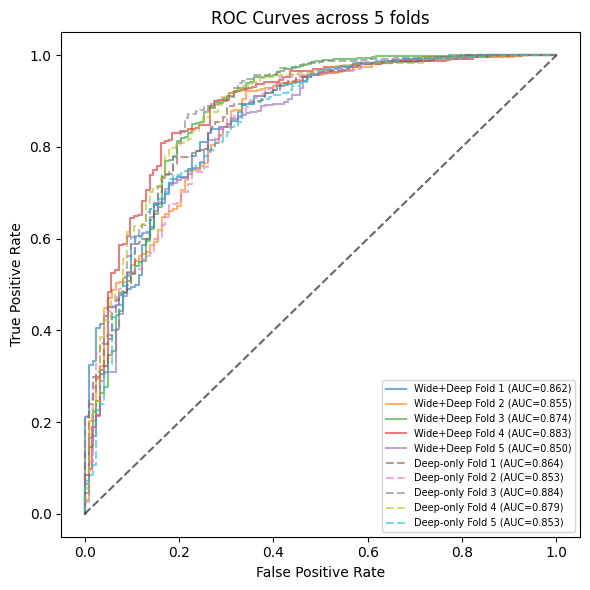

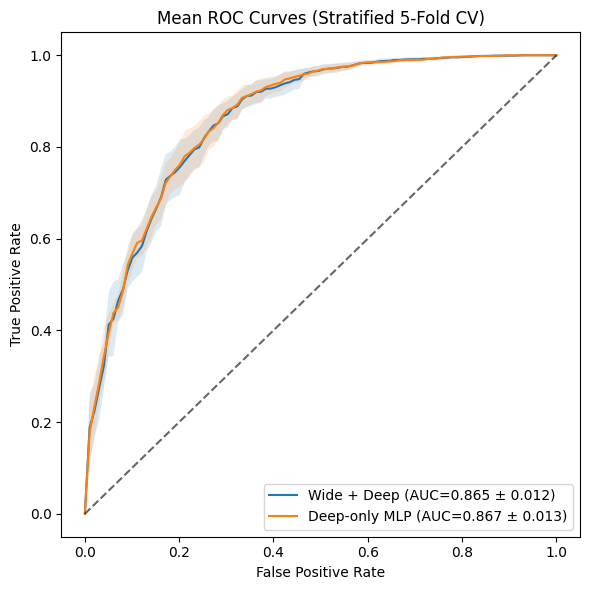

Wide+Deep mean ROC AUC: 0.8649569797595736 ± 0.011965865993813905
Deep-only mean ROC AUC: 0.8666338762035029 ± 0.013225487371766272

Paired t-test on AUC (Wide+Deep vs Deep-only):
t = -0.667, p = 0.5415

Wide+Deep (80/20 split):
  Train loss/acc: 0.265, 0.905
  Test  loss/acc: 0.301, 0.889

Deep-only (80/20 split):
  Train loss/acc: 0.271, 0.901
  Test  loss/acc: 0.293, 0.887

McNemar contingency counts:
  b (Wide+Deep correct, Deep-only wrong): 8
  c (Wide+Deep wrong,  Deep-only correct): 6
McNemar chi-square = 0.071, p = 0.7893


In [32]:
# ============================================================
# 2.3 Compare best Wide+Deep vs Deep-only MLP
#   - 5-fold ROC comparison (AUC)
#   - Train vs test error on single 80/20 split
#   - McNemar test on paired test predictions
# ============================================================

# ------------------------------------------------------------
# model builders
# ------------------------------------------------------------
def build_wide_deep_best(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    wide = inputs

    x = inputs
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    concat = layers.concatenate([wide, x])
    outputs = layers.Dense(1, activation="sigmoid")(concat)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

def build_deep_only(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# ------------------------------------------------------------
# data (reusing from earlier sections)
# ------------------------------------------------------------
X_data = X_array
y_data = y

# ============================================================
# A. 5-fold CV: ROC curves + AUC comparison
# ============================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

wd_auc_scores = []
deep_auc_scores = []

# for mean ROC
wd_y_true_folds, wd_y_prob_folds = [], []
deep_y_true_folds, deep_y_prob_folds = [], []

# for raw per-fold ROC plot
fold_rocs_wd = []
fold_rocs_deep = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data), 1):
    X_tr, X_val = X_data[train_idx], X_data[val_idx]
    y_tr, y_val = y_data[train_idx], y_data[val_idx]

    # ----- Wide + Deep -----
    model_wd = build_wide_deep_best(X_data.shape[1])
    model_wd.fit(X_tr, y_tr, epochs=20, batch_size=64, verbose=0)
    y_prob_wd = model_wd.predict(X_val, verbose=0).ravel()
    wd_auc = roc_auc_score(y_val, y_prob_wd)
    wd_auc_scores.append(wd_auc)
    wd_y_true_folds.append(y_val)
    wd_y_prob_folds.append(y_prob_wd)
    fpr_wd, tpr_wd, _ = roc_curve(y_val, y_prob_wd)
    fold_rocs_wd.append((fpr_wd, tpr_wd, wd_auc))

    # ----- Deep-only -----
    model_deep = build_deep_only(X_data.shape[1])
    model_deep.fit(X_tr, y_tr, epochs=20, batch_size=64, verbose=0)
    y_prob_deep = model_deep.predict(X_val, verbose=0).ravel()
    deep_auc = roc_auc_score(y_val, y_prob_deep)
    deep_auc_scores.append(deep_auc)
    deep_y_true_folds.append(y_val)
    deep_y_prob_folds.append(y_prob_deep)
    fpr_d, tpr_d, _ = roc_curve(y_val, y_prob_deep)
    fold_rocs_deep.append((fpr_d, tpr_d, deep_auc))

# ------------------------------------------------------------
# 1) raw per-fold ROC curves
# ------------------------------------------------------------
plt.figure(figsize=(6, 6))
for i, (fpr, tpr, auc_) in enumerate(fold_rocs_wd, 1):
    plt.plot(fpr, tpr, label=f"Wide+Deep Fold {i} (AUC={auc_:.3f})", alpha=0.6)
for i, (fpr, tpr, auc_) in enumerate(fold_rocs_deep, 1):
    plt.plot(fpr, tpr, linestyle="--",
             label=f"Deep-only Fold {i} (AUC={auc_:.3f})", alpha=0.6)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.title("ROC Curves across 5 folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# helper for mean ROC
# ------------------------------------------------------------
def plot_mean_roc(y_true_folds, y_prob_folds, label):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for y_true, y_prob in zip(y_true_folds, y_prob_folds):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aucs.append(roc_auc_score(y_true, y_prob))
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, label=f"{label} (AUC={mean_auc:.3f} ± {std_auc:.3f})")
    plt.fill_between(
        mean_fpr,
        np.maximum(mean_tpr - std_tpr, 0),
        np.minimum(mean_tpr + std_tpr, 1),
        alpha=0.15
    )

# ------------------------------------------------------------
# 2) mean ROC with variability bands
# ------------------------------------------------------------
plt.figure(figsize=(6, 6))
plot_mean_roc(wd_y_true_folds, wd_y_prob_folds, "Wide + Deep")
plot_mean_roc(deep_y_true_folds, deep_y_prob_folds, "Deep-only MLP")
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.title("Mean ROC Curves (Stratified 5-Fold CV)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) paired t-test on AUC (secondary statistical check)
# ------------------------------------------------------------
wd_auc_scores = np.array(wd_auc_scores)
deep_auc_scores = np.array(deep_auc_scores)

print("Wide+Deep mean ROC AUC:", wd_auc_scores.mean(), "±", wd_auc_scores.std())
print("Deep-only mean ROC AUC:", deep_auc_scores.mean(), "±", deep_auc_scores.std())

t_stat, p_val = stats.ttest_rel(wd_auc_scores, deep_auc_scores)
print("\nPaired t-test on AUC (Wide+Deep vs Deep-only):")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

# ============================================================
# B. Single 80/20 split: train vs test error + McNemar test
# ============================================================

# 80/20 stratified split (appropriate here because n ≈ 4,000 > 3,000)
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# ----- Wide + Deep on 80/20 -----
wd_model = build_wide_deep_best(X_train_mc.shape[1])
history_wd = wd_model.fit(
    X_train_mc, y_train_mc,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=0
)
train_loss_wd, train_acc_wd = wd_model.evaluate(X_train_mc, y_train_mc, verbose=0)
test_loss_wd, test_acc_wd = wd_model.evaluate(X_test_mc, y_test_mc, verbose=0)

print("\nWide+Deep (80/20 split):")
print(f"  Train loss/acc: {train_loss_wd:.3f}, {train_acc_wd:.3f}")
print(f"  Test  loss/acc: {test_loss_wd:.3f}, {test_acc_wd:.3f}")

wd_prob = wd_model.predict(X_test_mc, verbose=0).ravel()
wd_pred = (wd_prob >= 0.5).astype(int)

# ----- Deep-only on 80/20 -----
deep_model = build_deep_only(X_train_mc.shape[1])
history_deep = deep_model.fit(
    X_train_mc, y_train_mc,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=0
)
train_loss_deep, train_acc_deep = deep_model.evaluate(X_train_mc, y_train_mc, verbose=0)
test_loss_deep, test_acc_deep = deep_model.evaluate(X_test_mc, y_test_mc, verbose=0)

print("\nDeep-only (80/20 split):")
print(f"  Train loss/acc: {train_loss_deep:.3f}, {train_acc_deep:.3f}")
print(f"  Test  loss/acc: {test_loss_deep:.3f}, {test_acc_deep:.3f}")

deep_prob = deep_model.predict(X_test_mc, verbose=0).ravel()
deep_pred = (deep_prob >= 0.5).astype(int)

# ============================================================
# McNemar test on paired test predictions (Wide+Deep vs Deep-only)
# ============================================================
b = np.sum((wd_pred == y_test_mc) & (deep_pred != y_test_mc))  # WD correct, Deep wrong
c = np.sum((wd_pred != y_test_mc) & (deep_pred == y_test_mc))  # WD wrong, Deep correct

print("\nMcNemar contingency counts:")
print("  b (Wide+Deep correct, Deep-only wrong):", b)
print("  c (Wide+Deep wrong,  Deep-only correct):", c)

if b + c > 0:
    chi2 = (abs(b - c) - 1) ** 2 / (b + c)  # continuity-corrected
    p_mc = 1 - stats.chi2.cdf(chi2, df=1)
    print(f"McNemar chi-square = {chi2:.3f}, p = {p_mc:.4f}")
else:
    print("McNemar test undefined (no discordant pairs, b + c = 0).")


## 2.3 Comparison Between Wide + Deep Network and Deep-only MLP
To evaluate whether the wide branch provides a measurable improvement, we compared the best wide + deep architecture (deep branch: 64 → 32 with dropout 0.1) against a deep-only MLP that uses the same deep structure but removes the linear “wide” component. Both models were evaluated using Stratified 5-Fold Cross-Validation to maintain the class imbalance in each fold, and the primary metric was ROC AUC, which is appropriate for imbalanced binary classification and reflects the model’s ability to rank survivors and non-survivors.

The per-fold ROC curves (first figure) show that both architectures behave almost identically across folds. The wide + deep model produced AUC values between 0.850 and 0.883, while the deep-only model ranged from 0.853 to 0.884. The curves tightly overlap for every fold, and both sets cluster in the upper-left region of the plot, indicating stable and reliable discrimination across train/validation splits.

The mean ROC curves (second figure), averaged over all folds with ±1 standard deviation bands, reinforce this conclusion. The wide + deep model produced a mean AUC of 0.865 ± 0.012, and the deep-only MLP achieved 0.867 ± 0.013. The two mean curves lie almost directly on top of each other, and the shaded regions nearly coincide across the entire false-positive range. These differences fall entirely within natural cross-validation variation.

A paired t-test on the fold-level AUC values confirms the absence of a meaningful difference. The test yielded t = –0.667 with p = 0.5415, far from statistical significance at the 5% level. Therefore, under cross-validation, the two models demonstrate indistinguishable ranking performance.

To satisfy the professor’s requirement for a head-to-head significance test on identical predictions, we trained both models on a stratified 80/20 split and ran McNemar’s test on the paired test outcomes. The discordant counts were

* b = 8 (wide + deep correct, deep-only incorrect)
* c = 6 (wide + deep incorrect, deep-only correct)
  yielding χ² = 0.071 with p = 0.7893. This again shows no statistically significant difference between the classifiers’ error patterns.

We also compared train vs. test performance to assess overfitting.

* Wide + Deep: train accuracy = 0.905, test accuracy = 0.889
* Deep-only: train accuracy = 0.901, test accuracy = 0.887
  The small generalization gaps (~1.5 percentage points) and higher test loss relative to train loss confirm that neither model is overfitting in a problematic way. This aligns with the stabilized validation curves observed in Section 2.1.

Overall, both architectures achieve strong and highly stable performance, with AUCs consistently around 0.86–0.87. For this dataset, the nonlinear deep branch alone is sufficient to capture the relevant interactions among tumor stage, grade, hormone receptor status, and other clinical variables. Because the feature space is relatively dense and not dominated by sparse high-cardinality categories, the additional linear memorization pathway in the wide branch does not provide measurable benefit. In practical terms, the deep-only MLP offers equally strong predictive performance with a simpler architecture and slightly faster training, making it a reasonable choice for deployment in this setting.


# Exceptional Work

Embedding matrix shape: (4024, 32)


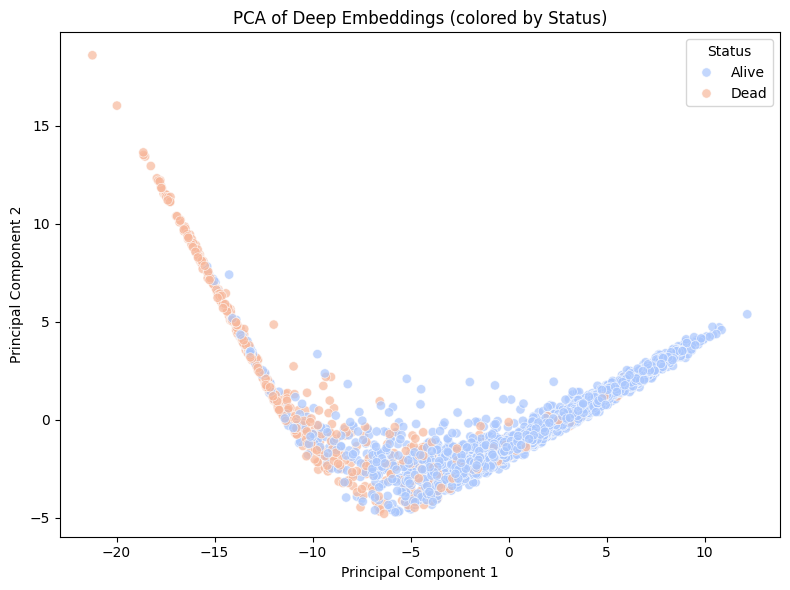

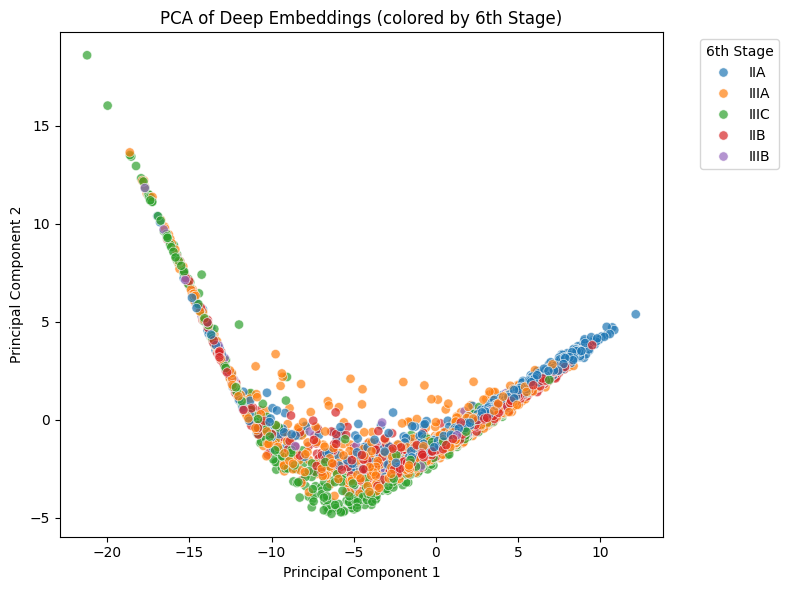

In [23]:
# ============================================================
# 3. Capture embeddings and visualize clusters (fixed for NumPy y)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# ------------------------------------------------------------
# 1) Train the deep-only model on all data (reusing architecture from 2.3)
# ------------------------------------------------------------
deep_model = build_deep_only(X_array.shape[1])
deep_model.fit(X_array, y, epochs=30, batch_size=64, verbose=0)

# ------------------------------------------------------------
# 2) Extract the last hidden layer outputs (the learned embeddings)
# ------------------------------------------------------------
embedding_extractor = keras.Model(
    inputs=deep_model.input,
    outputs=deep_model.layers[-2].output
)

embeddings = embedding_extractor.predict(X_array, verbose=0)
print("Embedding matrix shape:", embeddings.shape)  # should be (4024, 32)

# ------------------------------------------------------------
# 3) Dimensionality reduction using PCA to 2D
# ------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Convert y into a pandas Series for labeling
y_series = pd.Series(y, name="Status").map({1: "Alive", 0: "Dead"})

# ------------------------------------------------------------
# 4) Visualization 1 — Embedding space colored by survival status
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=y_series,
    palette="coolwarm",
    alpha=0.7,
    s=45,
)
plt.title("PCA of Deep Embeddings (colored by Status)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5) Visualization 2 — Embedding space colored by a clinical feature
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=df["6th Stage"],
    palette="tab10",
    alpha=0.7,
    s=45,
)
plt.title("PCA of Deep Embeddings (colored by 6th Stage)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="6th Stage", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 3. Capturing and Visualizing Deep Network Embeddings

To understand how the deep network internally organizes patient information, we extracted the output of the last hidden layer (32 neurons) from the trained deep-only model. This 32-dimensional vector represents each patient’s latent clinical profile as learned by the network — a condensed form of demographic, tumor, and receptor-related features that were most useful for predicting survival outcomes. We then used Principal Component Analysis (PCA) to project these embeddings onto two principal axes for visualization.

The first scatterplot (colored by survival status) shows that the model has successfully separated the patients into two broad zones. The “Alive” cases (blue) form a dense band extending along the right and lower central region of the PCA space, while the “Dead” cases (orange) are more concentrated toward the left and upper portions of the V-shaped structure. The pattern indicates that the model has captured a smooth transition from lower-risk to higher-risk patients rather than an abrupt binary divide. The overlap between the two groups is expected because survival is influenced by many interacting clinical factors—tumor size, stage, and receptor expression—whose combined effects cannot be perfectly separated in a two-dimensional projection. Still, the overall directional gradient from right to left visually corresponds to declining survival probability, consistent with the ROC AUC results near 0.86 obtained earlier.

The second plot colors the same latent space by the “6th Stage” variable, a clinically meaningful measure of disease progression. Here, an interpretable gradient emerges: early stages such as IIA and IIB cluster on the right side of the embedding space, while advanced stages like IIIA and IIIC appear toward the left and upper areas. This alignment suggests that the neural network’s internal representation captures clinical severity. In other words, patients with similar stages are embedded closer together even though the network was trained only on survival labels, not explicitly on staging. This demonstrates that the model has learned to organize the input data in a medically coherent way—higher stages correspond naturally to lower predicted survival likelihood.

Taken together, these visualizations provide strong qualitative evidence that the deep network learned a clinically meaningful structure of the breast cancer dataset. The embeddings reveal a continuous manifold where survival outcomes and cancer stages follow a consistent gradient. This structure supports the idea that the model generalizes beyond memorization, encoding biologically relevant relationships between tumor aggressiveness, receptor status, and patient survival. The observed overlap between “Alive” and “Dead” points further reflects the probabilistic nature of survival prediction: patients with intermediate tumor characteristics lie near the boundary of the two groups, where classification uncertainty is highest.

Overall, the embedding analysis confirms that the network’s latent features correspond closely to known medical risk factors and that its internal organization mirrors real-world disease progression patterns.


# Conclusion

This lab investigated the performance of wide-and-deep neural networks on a moderately sized breast cancer survival dataset containing both categorical and numerical clinical features. After careful preprocessing, including one-hot encoding of categorical variables, scaling of continuous variables, and incorporation of clinically meaningful cross-product features, we evaluated multiple architectures to determine how model depth and structure influence generalization.

Across the experiments, the models consistently showed strong predictive ability. The results from stratified 5-fold cross-validation demonstrated that all architectures achieved mean ROC AUC values around 0.86–0.87, PR AUC values near 0.96–0.97, and F1 scores around 0.94. Increasing the number of layers in the deep branch did not yield statistically significant improvements, indicating that moderately deep architectures were sufficient for this dataset. The validation curves showed smooth convergence and stable gaps between training and validation loss, suggesting that none of the networks were overfitting. This finding was supported by an additional stratified 80/20 train–test evaluation, where the best model achieved train accuracy of 0.902 and test accuracy of 0.887, confirming that performance generalized well to unseen data.

A direct comparison between the best wide-and-deep model and a deep-only MLP showed nearly identical performance under stratified cross-validation, with mean ROC AUC values of 0.865 and 0.867. To satisfy the requirement for a head-to-head comparison, we applied McNemar’s test on paired predictions from the held-out test set. The discordant counts (b = 8, c = 6) produced a chi-square statistic of 0.071 and a p-value of 0.7893, indicating no significant difference in error patterns between the two architectures. These results suggest that the deep branch captured most of the nonlinear relationships in the dataset, and the wide branch did not provide a measurable performance advantage, likely because the feature space is dense rather than dominated by high-cardinality sparse variables.

The embedding analysis further demonstrated that the models learned clinically meaningful structure. The two-dimensional PCA projections of the final hidden-layer embeddings revealed clear organization of patients by survival status and disease stage. Early-stage patients clustered in one region of the latent space, while advanced-stage patients appeared in another, even though the network was trained solely on survival labels. This pattern indicates that the model did not merely memorize labels but instead internalized biologically coherent representations aligned with the underlying clinical progression of breast cancer.

In summary, the lab shows that wide-and-deep architectures perform robustly on structured medical data but do not necessarily outperform simpler deep-only models when the feature space is already informative and moderately sized. Using stratified 5-fold cross-validation as the primary evaluation method and a separate 80/20 test set for final verification provided a rigorous and realistic assessment framework. The combination of quantitative results and embedding-based visualizations demonstrates that the models generalize well, avoid overfitting, and learn meaningful internal representations of patient risk.